In [16]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, SimpleRNN, Dense, GlobalAveragePooling1D, Dropout, LayerNormalization, Add, MultiHeadAttention
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import pandas as pd

In [18]:
# Assuming MAX_SEQUENCE_LENGTH, MAX_NB_WORDS, EMBEDDING_DIM are defined
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 250
EMBEDDING_DIM = 100

### Dataset

In [19]:
# Load your dataset
df = pd.read_csv(r"C:\Users\Himawan Putra\Documents\GitHub\Deep-Learning-Bank-Customer-Complaint-Analysis\01_prediksi\result\01_date_preprocessing_result.csv", sep=",")

### Splitting Data

In [20]:
# Tokenize text
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['narrative'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))


Found 45959 unique tokens.


In [21]:
# Convert text to sequences and pad them
X = tokenizer.texts_to_sequences(df['narrative'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (162411, 250)


In [22]:
# Define labels
y = np.argmax(df[['credit_card', 'credit_reporting', 'debt_collection', 'mortgages_and_loans', 'retail_banking']].values, axis=1)

In [23]:
# Split data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

### Modeling

In [24]:
# Define model parameters
num_heads = 4
num_units_1 = 32
num_units_2 = 16
dropout_rate1 = 0.4
dropout_rate2 = 0.1
num_classes = 5

# Model definition
input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,))
embedding_layer = Embedding(input_dim=MAX_NB_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH)(input_layer)

# First RNN layer
rnn_layer1 = SimpleRNN(num_units_1, return_sequences=True)(embedding_layer)

# First MultiHeadAttention layer
attention_output1 = MultiHeadAttention(num_heads=num_heads, key_dim=num_units_1)(rnn_layer1, rnn_layer1)
attention_output1 = Dense(num_units_1)(attention_output1)
add_layer1 = Add()([rnn_layer1, attention_output1])
norm_layer1 = LayerNormalization(epsilon=1e-6)(add_layer1)

# Dropout for regularization
dropout_layer1 = Dropout(dropout_rate1)(norm_layer1)

# Second RNN layer
rnn_layer2 = SimpleRNN(num_units_2, return_sequences=True)(dropout_layer1)

# Second MultiHeadAttention layer
attention_output2 = MultiHeadAttention(num_heads=num_heads, key_dim=num_units_2)(rnn_layer2, rnn_layer2)
attention_output2 = Dense(num_units_2)(attention_output2)
add_layer2 = Add()([rnn_layer2, attention_output2])
norm_layer2 = LayerNormalization(epsilon=1e-6)(add_layer2)

# Dropout for regularization
dropout_layer2 = Dropout(dropout_rate2)(norm_layer2)

# Global average pooling
global_avg_pooling = GlobalAveragePooling1D()(dropout_layer2)

# Dense output layer
output_layer = Dense(num_classes, activation='softmax')(global_avg_pooling)

# Build and compile the model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [25]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 250)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 250, 100)  │  5,000,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn          │ (None, 250, 32)   │      4,256 │ embedding[0][0]   │
│ (SimpleRNN)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 250, 32)   │     16,800 │ simple_rnn[0][0], │
│ (MultiHeadAttentio… │                   │            │ simple_rnn[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 250, 32)   │      1,056 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 250, 32)   │          0 │ simple_rnn[0][0], │
│                     │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 250, 32)   │         64 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 250, 32)   │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn_1        │ (None, 250, 16)   │        784 │ dropout_1[0][0]   │
│ (SimpleRNN)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 250, 16)   │      4,304 │ simple_rnn_1[0][… │
│ (MultiHeadAttentio… │                   │            │ simple_rnn_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 250, 16)   │        272 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 250, 16)   │          0 │ simple_rnn_1[0][… │
│                     │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 250, 16)   │         32 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 250, 16)   │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 16)        │          0 │ dropout_3[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 5)         │         85 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,027,653 (19.18 MB)

 Trainable params: 5,027,653 (19.18 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# Convert labels to one-hot encoding for train and validation sets
y_train = to_categorical(y_train, num_classes=num_classes)
y_val = to_categorical(y_val, num_classes=num_classes)

# Train the model with early stopping
num_epochs = 20
batch_size = 256
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    epochs=num_epochs, batch_size=batch_size,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping])


Epoch 1/20
  2/407 ━━━━━━━━━━━━━━━━━━━━ 27:39 4s/step - accuracy: 0.4102 - loss: 1.7011   

In [ ]:
# Plot training and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

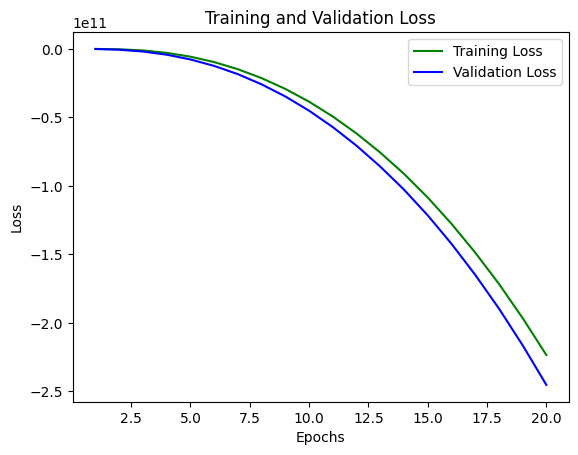

In [ ]:
# Plot kurva loss
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate on validation set
val_loss, val_acc = model.evaluate(X_val, y_val)
print("Validation Accuracy:", val_acc)

813/813 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5585 - loss: -252550496256.0000
Model Validation Accuracy: 0.5577234029769897


### Evaluating the Model

In [ ]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

1016/1016 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5624 - loss: -244724006912.0000
Test loss: -237912997888.0
Test accuracy: 0.5628790259361267
